In [1]:
#%reset -f -s

In [2]:
'''------------------------------------------------------------------
---------------------------------------------------------------------
LSTM Training
---------------------------------------------------------------------
Version: V1.7       Modified: 06.11.2024        William Siegle
---------------------------------------------------------------------
notebook can be converted to python script using: 
(python -m) jupytext --to py FILENAME.ipynb
------------------------------------------------------------------'''
from pathlib import Path

# SETTINGS ------------------------------------------------------------------------
CONFIG = {
    # SYSTEM: ---------------------------------------------------------------------
    "ROOT":             Path('../..').resolve(),
    "INPUT_LOCATION":   Path("TripSequences", "trips_processed_final"), 
    "OUTPUT_LOCATION":  Path("src", "models", "pth"),
    "GPU_SELECT":       0, # {0,1,2,3, None: CPU only}
    "TORCH_SEED"  :     24,

    # DATA PREPROCESSING: ---------------------------------------------------------
    "TRAIN_VAL_TEST":   [0.8, 0.15, 0.05], # [train, val, test splits]
    "MAX_FILES":        300, # None: all files
    "SCALERS":          {'feature_scaler': 'MaxAbsScaler()', 'target_scaler': 'MinMaxScaler(feature_range=(0, 1))'},

    # FEATURES: -------------------------------------------------------------------
    "FEATURES":         ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 'roadgrad_cval_pt', "vehweight_cval_pt", "accelpdlposn_cval", 
                         "bs_brk_cval", "elcomp_pwrcons_cval","epto_pwr_cval", "motortemperature_pti1", "powerstagetemperature_pti1", 'airtempinsd_cval_hvac', 
                         'brktempra_cval', 'selgr_rq_pt'],
    "TARGETS":          ['hv_bat_soc_cval_bms1'],

    # MODEL: -----------------------------------------------------------------------
    "HIDDEN_SIZE":      128,    # features in the hidden state h
    "NUM_LAYERS":       2,      # recurrent layers for stacked LSTMs. Default: 1
    "DROPOUT":          0.4,
    "SEQ_LENGTH":       60,
    
    # TRAINING & OPTIMIZER: --------------------------------------------------------
    "NUM_EPOCHS":       2,
    "BATCH_SIZE":       16,   # [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
    "LEARNING_RATE":    4e-4,   # 0.001 lr
    "OPTIMIZER":        "torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = 1e-4)",      
                            # weight_decay = 1e-4     # weight decay coefficient (default: 1e-2)
                            # betas = (0.9, 0.95),    # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
                            # eps = 1e-8,             # term added to the denominator to improve numerical stability (default: 1e-8)
    "LRSCHEDULER":      "torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 2, factor = 0.5, min_lr = 1e-6)",

    # LOSS FUNCTION: ---------------------------------------------------------------
    "CRITERION":        "nn.SmoothL1Loss()", #['nn.MSELoss()', 'nn.L1Loss()', 'nn.SmoothL1Loss()', 'nn.HuberLoss()', 'MASE()']


    # METRICS: ---------------------------------------------------------------------

    # SAVE & LOAD: -----------------------------------------------------------------

}

for key in CONFIG: globals()[key] = CONFIG[key]

___
LOCATE DEVICES & SYSTEM FOLDERS

In [3]:
# LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  ---------------------------
# ----------------------------------------------------------------------------------------
import sys, os
global ROOT, DATA_PATH
if 'ROOT' not in globals(): ROOT = Path('../..').resolve()
print(f"{'-'*60}\nDirectories:\n  {ROOT}:\t\t\t{', '.join([_.name for _ in ROOT.glob('*/')])}")
sys.path.append(os.path.abspath(ROOT))
from data import get_data_path  # paths set in "data/__init__.py"
DATA_PATH = get_data_path()
print(f"  {DATA_PATH}:\t\t\t{', '.join([_.name for _ in DATA_PATH.glob('*/')])}")

# INTERNAL MODULE IMPORTS ----------------------------------------------------------------
# ----------------------------------------------------------------------------------------
from src.utils.TripDataset import *
from src.utils.train_model import *

# NOTEBOOK / SCRIPT SETTINGS -------------------------------------------------------------
# ----------------------------------------------------------------------------------------
global IS_NOTEBOOK
IS_NOTEBOOK = False
try:    # if running in IPython
    shell = get_ipython().__class__.__name__ # type: ignore 
    from IPython.display import display, HTML, Javascript, clear_output
    from IPython.core.magic import register_cell_magic
    @register_cell_magic    # cells can be skipped by using '%%skip' in the first line
    def skip(line, cell): return
    from tqdm.notebook import tqdm as tqdm_nb
    IS_NOTEBOOK = True
    print(f"{'-'*60}\nRunning in notebook mode")
except (NameError, ImportError):    # if running in script
    from tqdm import tqdm as tqdm
    from tabulate import tabulate
    print(f"{'-'*60}\nRunning in script mode")
    
# GENERAL MODULE IMPORTS -----------------------------------------------------------------
# ----------------------------------------------------------------------------------------
import math, time, random, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import pyarrow.parquet as pq
from copy import deepcopy
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline
#from sklearn.compose import ColumnTransformer
from scipy.signal import savgol_filter

import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
from torch.nn.utils.rnn import pack_sequence, pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torchmetrics.functional import mean_squared_error
torch.set_default_dtype(torch.float32); torch.manual_seed(TORCH_SEED);

from sklearn.metrics import root_mean_squared_error
from pytorch_forecasting.metrics import MASE
#from darts import TimeSeries
#from darts.models import ExponentialSmoothing

------------------------------------------------------------
Directories:
  C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-eR-PINN:			.git, archive, data, project, ref, src, test
  C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data:			new_folder, OLD, processed, TripSequences
------------------------------------------------------------
Running in notebook mode


In [4]:
# DEVICE SELECTION ---------------------------------------------------------------------
global DEVICE
print(f"{'-'*60}\nTorch version: ", torch.__version__)
if not torch.cuda.is_available() or GPU_SELECT is None:
    DEVICE = torch.device("cpu")
else:
    DEVICE = torch.device(f"cuda:{GPU_SELECT}")
print(f"Using: -->  {str(DEVICE).upper()}")

------------------------------------------------------------
Torch version:  2.5.1+cpu
Using: -->  CPU


___
DATA PREPROCESSING

In [5]:
# FILE SOURCES ---------------------------------------------------------------
input_folder = Path(DATA_PATH, INPUT_LOCATION) # Trip parquet files
pth_folder = Path(ROOT, OUTPUT_LOCATION)
print(f"{'-'*60}\nInput Data:\t{input_folder}\nStore model in:\t{pth_folder}")

# PREPARE TRAIN & TEST SET ---------------------------------------------------
all_files = [Path(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".parquet")]
files = all_files[:MAX_FILES]
print(f"{'-'*60}\nTotal Files:\t{len(files)}")
# ---------------------------------------------------
df = pd.read_parquet(Path(input_folder, random.choice(files)), engine='fastparquet')
all_signals = df.columns
assert len(all_signals) == 44

# FILTER INPUT FILES --------------------------------------------------------
# generate lengths of all files by reading metadata or using presaved lengths
try:
    presaved_lengths = pd.read_pickle(Path(ROOT, 'data', 'df_files_lengths.pickle'))
    presaved_lengths = presaved_lengths.set_index('FileName').to_dict()['Length']
    trip_lengths = [presaved_lengths[file.name] for file in files]
except:
    print(f"{'-'*60}\nObtaining sequence lengths... (may take up to 5 minutes)")
    trip_lengths = [pq.read_metadata(file).num_rows for file in files]

# discard all items shorter than min_seq_length
min_seq_length = 600
filtered_files = []
filtered_lengths = []
for file, length in zip(files, trip_lengths):
    if length > min_seq_length: 
        filtered_files.append(file)
        filtered_lengths.append(length)

# replace lists with only filtered items
files = filtered_files
trip_lengths = filtered_lengths
print(f"Filtered Files:\t{len(files)}\n{'-'*60}")

# SORT INPUT FILES BY SEQUENCE LENGTH --------------------------------------
# this is needed in order to later sort the sequence by their length
file_length_mapping = sorted([(file.name, length, idx) for idx, (file, length) in enumerate(zip(files, trip_lengths))], \
    key=lambda x: x[1], reverse=True)

file_length_df = pd.DataFrame(file_length_mapping, columns=['FileName', 'Length', 'Index'])
print(file_length_df)

indices_by_length = file_length_df['Index'].to_list()
sorted_trip_lengths = file_length_df['Length'].to_list()

------------------------------------------------------------
Input Data:	C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data\TripSequences\trips_processed_final
Store model in:	C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-eR-PINN\src\models\pth
------------------------------------------------------------
Total Files:	300
Filtered Files:	211
------------------------------------------------------------
              FileName  Length  Index
0     V101_T37.parquet   16591    210
1    V101_T126.parquet   12939     20
2    V101_T335.parquet   12395    190
3     V101_T18.parquet   12377     65
4    V101_T174.parquet   10587     59
..                 ...     ...    ...
206  V101_T245.parquet     654    122
207  V101_T310.parquet     648    177
208  V101_T300.parquet     607    169
209  V101_T283.parquet     605    154
210  V101_T287.parquet     604    158

[211 rows x 3 columns]


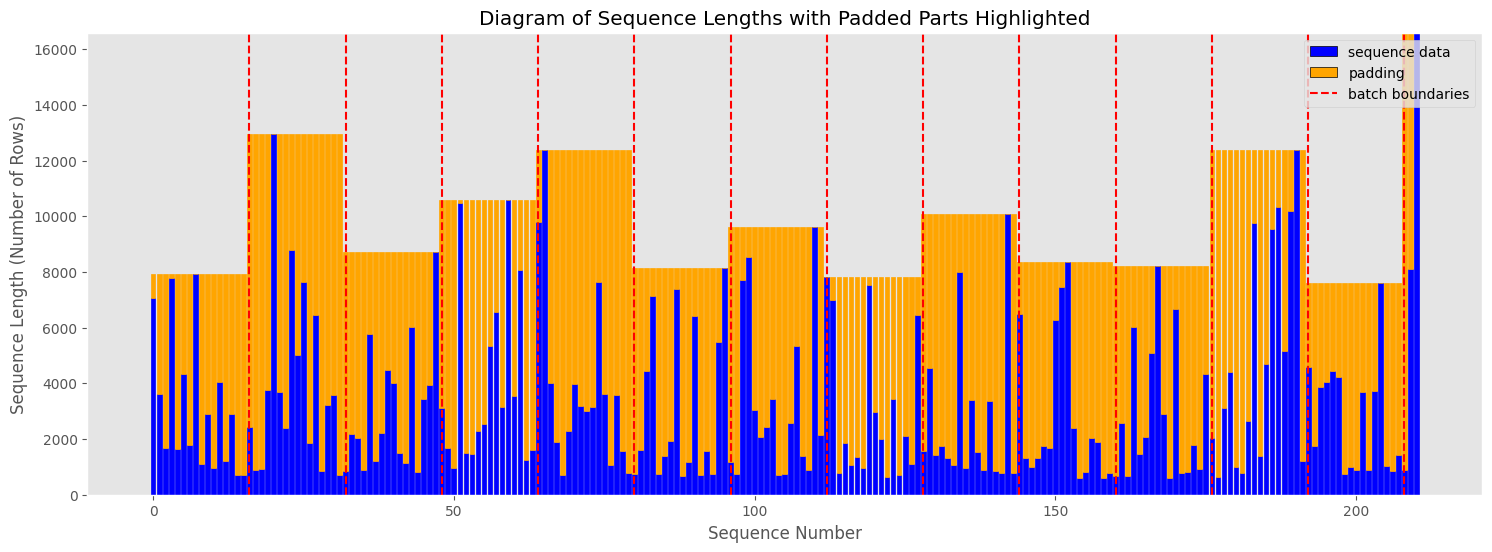

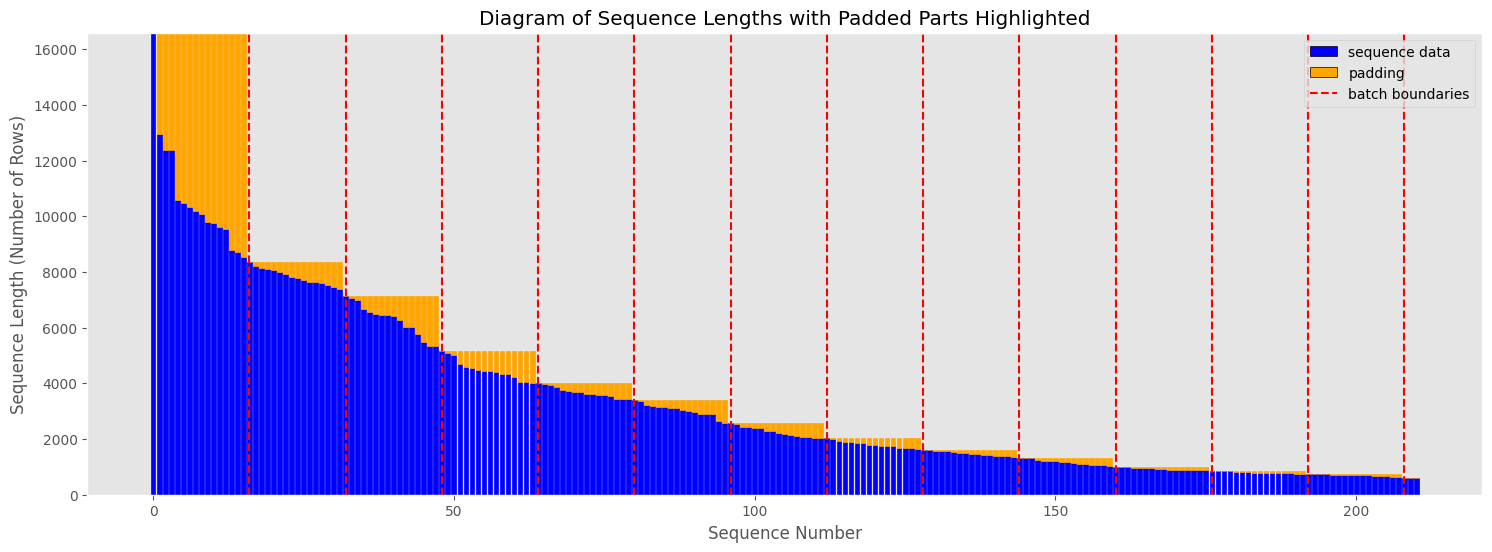

padding values (unsorted) = 64 %
padding values (sorted) = 11 %


In [6]:
#%%skip
def plot_sequence_lengths(batch_size, trip_lengths):
    # Calculate the number of batches
    num_batches = int(np.ceil(len(trip_lengths) / batch_size))
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(18, 6))
    ratios = []
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(trip_lengths))
        batch_lengths = trip_lengths[start_idx:end_idx]

        ax.bar(range(start_idx, end_idx), batch_lengths, color='blue', edgecolor='blue') # Plot the actual sequence lengths

        max_length = max(batch_lengths)
        blue_area = sum(batch_lengths)
        orange_area = sum(max_length - length for length in batch_lengths)
        ratio = orange_area / (blue_area + orange_area)
        ratios.append(ratio)

        # Highlight the padded parts
        for j in range(start_idx, end_idx): ax.bar(j, max_length - batch_lengths[j - start_idx], bottom=batch_lengths[j - start_idx], color='orange', edgecolor='orange')

        # Add vertical red dashed lines at batch boundaries
        if i > 0: ax.axvline(x=start_idx, color='red', linestyle='--')

    # Set labels and title
    ax.set_xlabel('Sequence Number')
    ax.set_ylabel('Sequence Length (Number of Rows)')
    ax.set_title('Diagram of Sequence Lengths with Padded Parts Highlighted')
    handles = [plt.Rectangle((0,0),1,1,color=c,ec="k") if c != "red" else plt.Line2D([0], [0], color=c, linestyle='--') for c in ["blue", "orange", "red"]]
    labels = ["sequence data", "padding", "batch boundaries"]
    ax.legend(handles, labels, loc="upper right"); ax.grid(False); plt.show();

    return ratios

ratios_1 = plot_sequence_lengths(BATCH_SIZE, trip_lengths)
ratios_2 = plot_sequence_lengths(BATCH_SIZE, sorted_trip_lengths)

# Calculate and print the ratio between blue and orange areas for both diagrams
print(f"padding values (unsorted) = {np.mean(ratios_1)*100:.0f} %")
print(f"padding values (sorted) = {np.mean(ratios_2)*100:.0f} %")

In [7]:
# INPUT & TARGET SPECIFICATION ---------------------------------------------------
# these signals are required for the physical Model calculation:
base_signals = ["signal_time", "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 
"hv_batpwr_cval_bms1", "emot_pwr_cval","bs_roadincln_cval", "roadgrad_cval_pt"]

# these signals have to be dropped in order for appropriate training:
columns_to_drop = ["hv_batmomavldischrgen_cval_1", "latitude_cval_ippc", "longitude_cval_ippc", "signal_time"]

# ---------------------------------------------------
selection_1 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 'roadgrad_cval_pt', "vehweight_cval_pt", "accelpdlposn_cval", "bs_brk_cval", "elcomp_pwrcons_cval",
               "epto_pwr_cval", "motortemperature_pti1", "powerstagetemperature_pti1", 'airtempinsd_cval_hvac', 'brktempra_cval', 'selgr_rq_pt']
selection_2 = ["hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "hv_batpwr_cval_bms1", "emot_pwr_cval","bs_roadincln_cval", "roadgrad_cval_pt"]
selection_3 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "bs_roadincln_cval", "vehweight_cval_pt"]

# FEATURE SELECTION  --------------------------------------
# ---------------------------------------------------------
target_column = TARGETS
input_columns = FEATURES

In [8]:
# FEATURE NORMALIZATION/SCALING -----------------------------------------------------------------
scaler = eval(SCALERS['feature_scaler'])
target_scaler = eval(SCALERS['target_scaler'])

# DATA SET SPLITTING -----------------------------------------------------------------------
train_subset, val_subset, test_subset = random_split(files, TRAIN_VAL_TEST)

In [9]:
# GENERATE DATALOADERS  ---------------------------------------------------------------
'''
Notes: for each of the three subsets, the following steps are performed:
    1. Sort each subset by descending sequence lengths based on the obtained indices
    2. Create a (custom) TripDataset object to select the input and target columns and apply the scalers. In case
         of the training subset, the scalers will be fitted to the training set first.
    3. Create a (custom) BatchDataset object of the corresponding TripDataset to handle the sequence padding before using 
            the DataLoader to create the batches.
    4. The DataLoader will then be used to iterate over the batches during training. To use the integrated collate_fn function
            of the DataLoader, the batch_size has to be set to 1. The actual batch size is then handled by the BatchDataset object.
    5. The collate_fn that is integrated in the DataLoader will automatically handle the shuffling, padding and packing
            of the sequences. The DataLoader will return a tuple of (packed_inputs, padded_targets, lengths), where
            the packed_inputs are PackedSequence objects that can be efficiently processed by RNNs.
            [Output tuple of types (<class 'torch.nn.utils.rnn.PackedSequence'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>)]

Note: shuffling will be done batchwise, however inside each batch the sequences  will remain sorted by length

*Note: Because of the BatchDataset object in the train loader, "batch_size" refers to the number of batches to feed, not the 
number of samples in a batch. Also, the "drop_last" argument is useless due to this.
'''

# -------------------------------------------------------------------
dataloader_settings = {
    'batch_size': 1,                # see *Note above
    'shuffle': True,                # shuffle the batches before each epoch
    'collate_fn': collate_fn,       # include optional arguments
    'num_workers': 4,               # number of workers
    'pin_memory': False if DEVICE.type == 'cpu' else True
}

# TRAIN  ------------------------------------------------------------
train_subset.indices = [i for i in indices_by_length if i in set(list(train_subset.indices))]
train_dataset = TripDataset(train_subset, input_columns, target_column, scaler, target_scaler, fit=True)
train_dataset_batches = create_batches(train_dataset, BATCH_SIZE)
train_loader = DataLoader(train_dataset_batches, **dataloader_settings)

# VAL --------------------------------------------------------------
val_subset.indices = [i for i in indices_by_length if i in set(list(val_subset.indices))]
val_dataset = TripDataset(val_subset, input_columns, target_column, scaler, target_scaler, fit=False)
val_dataset_batches = create_batches(val_dataset, BATCH_SIZE)
val_loader = DataLoader(val_dataset_batches, **dataloader_settings)

# TEST -------------------------------------------------------------
test_subset.indices = [i for i in indices_by_length if i in set(list(test_subset.indices))]
test_dataset = TripDataset(test_subset, input_columns, target_column, scaler, target_scaler, fit=False)
test_dataset_batches = create_batches(test_dataset, BATCH_SIZE)
test_loader = DataLoader(test_dataset_batches, **dataloader_settings)

fitting Scalers: MaxAbsScaler, MinMaxScaler


	50% of the fitting done...
Done. Create DataSets and DataLoaders...
Number of batches created: 11
Number of batches created: 2
Number of batches created: 1


In [10]:
# Print the size of the datasets ----------------------------------
print(f"{'-'*60}\nTrain size:  {len(train_dataset)}\t\t(Files: {len(train_subset)})")
print(f'Val. size:   {len(val_dataset)}\t\t(Files: {len(val_subset)})')
print(f'Test size:   {len(test_dataset)}\t\t(Files: {len(test_subset)}) \n {"-"*60}')
if train_dataset.__len__() != sum(len(data) for data in train_dataset.data): print("Warning: Train Dataset Length Mismatch")

subset_files = {"train":    list(train_dataset.file_list),
                "val":      list(val_dataset.file_list),
                "test":     list(test_dataset.file_list)}
print(f"first 3 train files: {[os.path.basename(_) for _ in subset_files['train'][:3]]}")

------------------------------------------------------------
Train size:  606273		(Files: 169)
Val. size:   103517		(Files: 32)
Test size:   14775		(Files: 10) 
 ------------------------------------------------------------
first 3 train files: ['V101_T37.parquet', 'V101_T126.parquet', 'V101_T335.parquet']


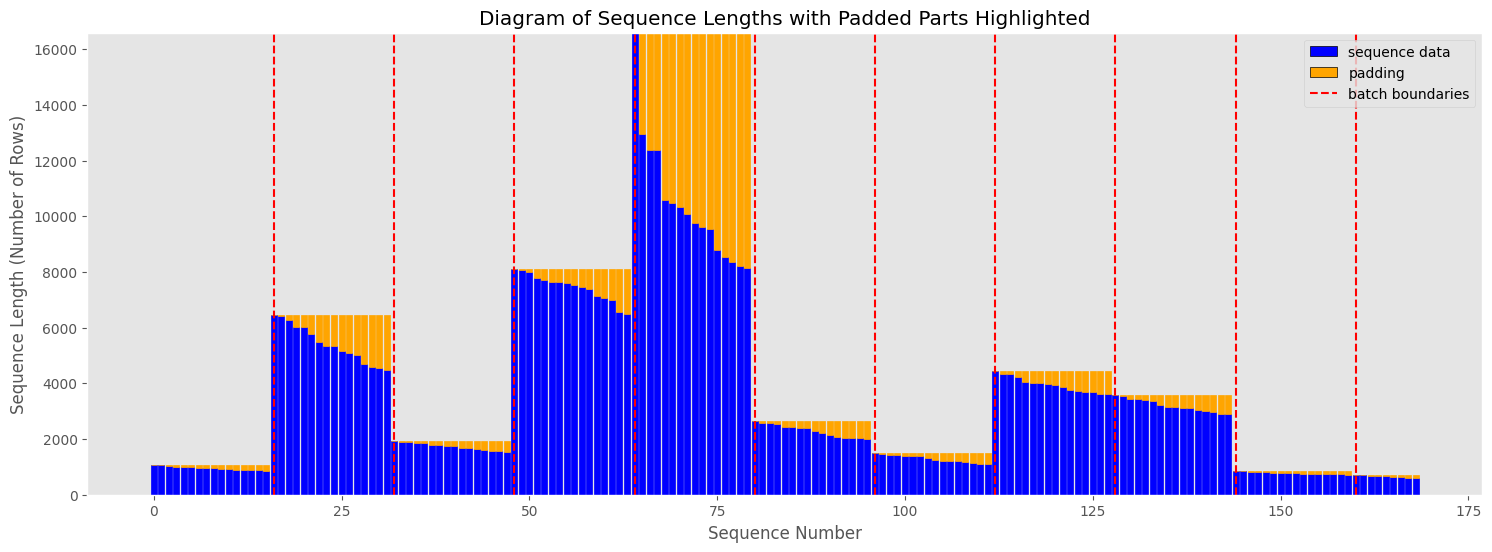

padding values = 13 %


In [11]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 6))
ratios = []
for batch_idx, (padded_inputs, padded_targets, lengths) in enumerate(train_loader):
    start_idx = batch_idx * BATCH_SIZE
    end_idx = start_idx + len(lengths)
    
    # Plot the actual sequence lengths
    ax.bar(range(start_idx, end_idx), lengths, color='blue', edgecolor='blue')
    
    # Highlight the padded parts
    max_length = max(lengths)
    blue_area = sum(lengths)
    orange_area = sum(max_length - length for length in lengths)
    ratio = orange_area / (blue_area + orange_area)
    ratios.append(ratio)

    for j in range(start_idx, end_idx): ax.bar(j, max_length - lengths[j - start_idx], bottom=lengths[j - start_idx], color='orange', edgecolor='orange')

    # Add vertical red dashed lines at batch boundaries
    if batch_idx > 0: ax.axvline(x=start_idx, color='red', linestyle='--')

# Set labels and title
ax.set_xlabel('Sequence Number')
ax.set_ylabel('Sequence Length (Number of Rows)')
ax.set_title('Diagram of Sequence Lengths with Padded Parts Highlighted')
handles = [plt.Rectangle((0,0),1,1,color=c,ec="k") if c != "red" else plt.Line2D([0], [0], color=c, linestyle='--') for c in ["blue", "orange", "red"]]
labels = ["sequence data", "padding", "batch boundaries"]
ax.legend(handles, labels, loc="upper right"); ax.grid(False); plt.show(); 

# Calculate and print the ratio between blue and orange areas
print(f"padding values = {np.mean(ratios)*100:.0f} %")

In [12]:
# Iterate through the train_loader and print an example of a PackedSequence
for batch_idx, (packed_inputs, padded_targets, lengths) in enumerate(train_loader):
    #print(f"Packed Inputs (Batch {batch_idx}):\n{packed_inputs}")
    print(type(packed_inputs), type(packed_inputs.data), type(packed_inputs.batch_sizes))
    print(type(padded_targets), type(lengths))
    print(packed_inputs.data.shape)
    print(len(packed_inputs.batch_sizes))
    print(lengths)
    break

<class 'torch.nn.utils.rnn.PackedSequence'> <class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([20677, 14])
1510
tensor([1510, 1455, 1434, 1412, 1379, 1377, 1374, 1325, 1239, 1228, 1227, 1212,
        1158, 1143, 1117, 1087])


In [13]:
# LSTM NETWORK -----------------------------------------------------------------------
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length, dropout, device=DEVICE):
        super(LSTM1, self).__init__()

        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers    # number of layers
        self.dropout = dropout
        self.seq_length = seq_length    # sequence length

        # LSTM CELL --------------------------------
        self.lstm = nn.LSTM(
            self.input_size,            # The number of expected features in the input x
            self.hidden_size,           # The number of features in the hidden state h
            self.num_layers,            # Number of recurrent layers for stacked LSTMs. Default: 1
            batch_first=True,           # If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Default: False
            bias=True,                  # If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            dropout=self.dropout,       # usually: [0.2 - 0.5], introduces a Dropout layer on the outputs of each LSTM layer except the last layer, (dropout probability). Default: 0
            bidirectional=False,        # If True, becomes a bidirectional LSTM. Default: False
            proj_size=0,                # If > 0, will use LSTM with projections of corresponding size. Default: 0
            device=device
        )

        self.relu = nn.ReLU()
        self.fc_test = nn.Linear(hidden_size, 1)
    
    def forward(self, input, batch_size=None):
        # Propagate input through LSTM
        out, _ = self.lstm(input)

        # Unpack the output
        out, _ = pad_packed_sequence(out, batch_first=True)

        # Output layers
        out = self.relu(out)  # relu
        out = self.fc_test(out[:, -1, :])  # Use the last output for prediction

        return out


In [14]:
# MODEL CONFIGURATION -----------------------------------------------------------------------

# LAYERS --------------------------------
input_size = len(input_columns)     # expected features in the input x
hidden_size = HIDDEN_SIZE           # features in the hidden state h
num_layers = NUM_LAYERS             # recurrent layers for stacked LSTMs. Default: 1
num_classes = 1                     # output classes (=1 for regression)

# INSTANTIATE MODEL --------------------
model = LSTM1(input_size, HIDDEN_SIZE, NUM_LAYERS, SEQ_LENGTH, DROPOUT).to(DEVICE)
print(f"{'-'*60}\n", model)


------------------------------------------------------------
 LSTM1(
  (lstm): LSTM(14, 128, num_layers=2, batch_first=True, dropout=0.4)
  (relu): ReLU()
  (fc_test): Linear(in_features=128, out_features=1, bias=True)
)


In [15]:
# TRAINING CONFIGURATION -----------------------------------------------------------------------

# OPTIMIZER -----------------------------
# common optimizers: ['torch.optim.Adam', 'torch.optim.SGD', 'torch.optim.RMSprop']
if 'OPTIMIZER' in globals(): optimizer = eval(OPTIMIZER)
else:
    optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE,
        weight_decay = 1e-4      # weight decay coefficient (default: 1e-2)
        #betas = (0.9, 0.95),    # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
        #eps = 1e-8,             # term added to the denominator to improve numerical stability (default: 1e-8)
)

# LR SCHEDULER -----------------------------
if 'LRSCHEDULER' in globals(): scheduler = eval(LRSCHEDULER)
else: scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 2, factor = 0.5, min_lr = 1e-6)

# LOSS FUNCTION ----------------------------------------------------------------
def loss_fn(model_output, target):
    loss = F.mse_loss(model_output, target) # mean-squared error for regression
    return loss

# or define criterion function:
criterion_list = [nn.MSELoss(), nn.L1Loss(), nn.SmoothL1Loss(), nn.HuberLoss(), MASE()]

if 'CRITERION' in globals(): criterion = eval(CRITERION)
else: criterion = nn.SmoothL1Loss()

# ------------------------------------------------------------------------------
# print Model and Optimizer state_dicts
print(f"{'-'*60}\nModel state_dict:")
for param_tensor in model.state_dict(): print(f"{param_tensor}:\t {model.state_dict()[param_tensor].size()}")
print(f"{'-'*60}\n{optimizer}\n{'-'*60}\n")

------------------------------------------------------------
Model state_dict:
lstm.weight_ih_l0:	 torch.Size([512, 14])
lstm.weight_hh_l0:	 torch.Size([512, 128])
lstm.bias_ih_l0:	 torch.Size([512])
lstm.bias_hh_l0:	 torch.Size([512])
lstm.weight_ih_l1:	 torch.Size([512, 128])
lstm.weight_hh_l1:	 torch.Size([512, 128])
lstm.bias_ih_l1:	 torch.Size([512])
lstm.bias_hh_l1:	 torch.Size([512])
fc_test.weight:	 torch.Size([1, 128])
fc_test.bias:	 torch.Size([1])
------------------------------------------------------------
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0004
    maximize: False
    weight_decay: 0.0001
)
------------------------------------------------------------



In [ ]:
'''
######################## 
# ------------->  TO BE INCLUDED IN train_model.py'''

#############################################################################################################
# -----------------------------------------------------------------------------------------------------------
class Trainer_packed(TorchRLTrainer):

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer, loss_fn: nn.Module, 
                 train_loader: DataLoader, num_epochs: int, device: torch.device, 
                 is_notebook: bool = False, val_loader: DataLoader = None, 
                 scheduler: torch.optim.lr_scheduler._LRScheduler = None, state: dict = None, 
                 use_mixed_precision: bool = False, clip_value = None):

        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.train_loader = train_loader
        self.num_epochs = num_epochs
        self.device = device
        self.is_notebook = is_notebook
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.state = state
        self.use_mixed_precision = use_mixed_precision if torch.cuda.is_available() else False
        if self.use_mixed_precision: self.scaler = GradScaler()  # Initialize GradScaler
        self.clip_value = clip_value

    def validate_model(self, epoch: int) -> float:
        self.model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation
            for inputs, targets in self.val_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs.squeeze(), targets)
                val_loss += loss.item()
        val_loss /= len(self.val_loader)  # Calculate average validation loss
        if self.scheduler:
            lr1 = self.scheduler.get_last_lr()[0]
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss
            lr2 = self.scheduler.get_last_lr()[0]
            self.lr_history.append(lr2)
            if lr1 != lr2:
                print(f"Learning rate updated after epoch {epoch}: {lr1} -> {lr2}")
        return val_loss

    # TRAINING ROUTINE DEFINITION -----------------------------------------------------------------
    def train_model(self) -> dict:
       # output info on training process
        print(f"{'-'*60}\nTraining Started.\tProcess ID: {os.getpid()} \n{'-'*60}\n"
              f"Model: {self.model.__class__.__name__}\t\tParameters on device: {str(next(self.model.parameters()).device).upper()}\n{'-'*60}\n"
              f"Train/Batch size:\t{len(self.train_loader.dataset)} / {self.train_loader.batch_size}\n"
              f"Loss:\t\t\t{self.loss_fn}\nOptimizer:\t\t{self.optimizer.__class__.__name__}\nLR:\t\t\t"
              f"{self.optimizer.param_groups[0]['lr']}\nWeight Decay:\t\t{self.optimizer.param_groups[0]['weight_decay']}\n{'-'*60}")
        
        # Load state dict if provided
        start_epoch = 1
        if self.state:
            self.model.load_state_dict(self.state['model_state_dict'])
            self.optimizer.load_state_dict(self.state['optimizer_state_dict'])
            self.train_losses = self.state['train_losses']
            self.lr_history = self.state['lr_history']
            self.val_losses = self.state['val_losses']
            self.training_table = self.state['training_table']
            start_epoch = self.state['epoch'] + 1
        else:
            self.train_losses = [] 
            self.val_losses = []  
            self.training_table = []  
            self.lr_history = []
            if self.is_notebook: display_html(HTML(initialize_table()))

        # TRAINING LOOP:
        start_time = time.perf_counter()
        for epoch in range(start_epoch, self.num_epochs + 1):
            self.model.train()  # set model to training mode
            running_loss = 0.0
            num_iterations = math.ceil(len(self.train_loader.dataset) / self.train_loader.batch_size)
            header_printed = False

            tqdm_version = tqdm_nb if self.is_notebook else tqdm
            with tqdm_version(enumerate(self.train_loader, 1), unit="batch", total=num_iterations, leave=False) as tepoch:
                for iter, (inputs, targets, length) in tepoch:  # ----> note: (packed_inputs, padded_targets, lengths)
                    tepoch.set_description(f"Epoch {epoch}/{self.num_epochs}")

                    # -------------------------------------------------------------
                    # Move data to the GPU
                    inputs, targets = inputs.to(self.device), targets.to(self.device)

                    # zero gradients -> forward pass -> obtain loss function -> apply backpropagation -> update weights:
                    self.optimizer.zero_grad()

                    # A) use mixed precision calculation
                    if self.use_mixed_precision:
                        with autocast():  # Enable autocast for mixed precision training
                            outputs = self.model(inputs)   # inputs are packed, outputs are not ! --> see forward method in model
                            loss = self.loss_fn(outputs.squeeze(), targets)
                        self.scaler.scale(loss).backward()  # Scale the loss and perform backward pass
                        if self.clip_value is not None:
                            nn.utils.clip_grad_value_(self.model.parameters(), clip_value=self.clip_value)  # optional: Gradient Value Clipping
                        self.scaler.step(self.optimizer)  # Update model parameters
                        self.scaler.update()  # Update the scale for next iteration

                    # B) Normal precision calculation
                    else:
                        print(f"Shape of inputs: {inputs.data.shape}")
                        outputs = self.model(inputs)  # inputs are packed, outputs are not ! --> see forward method in model
                        print(f"Shape of outputs: {outputs.shape}")
                        loss = self.loss_fn(outputs, targets)  # UPDATE: outpts.squeeze() --> outputs
                        loss.backward()
                        if self.clip_value is not None:
                            nn.utils.clip_grad_value_(self.model.parameters(), clip_value=self.clip_value)  # optional: Gradient Value Clipping
                        self.optimizer.step()

                    # -------------------------------------------------------------
                    # Update the performance table
                    if iter % (num_iterations // 4) == 0 and iter != num_iterations // 4 * 4:
                        add_row(self.training_table, f" ", f"{iter}", f"{loss.item():.6f}", " ")
                        if self.is_notebook:
                            display_html(HTML(f"""<script>addRow("", "{iter}", "{loss.item():.6f}", "");</script>"""))
                        else:
                            print_row(self.training_table)
                    elif iter == 1:
                        add_row(self.training_table, f"{epoch}/{self.num_epochs}", f"{iter}/{num_iterations}", f"{loss.item():.6f}", " ")
                        if self.is_notebook:
                            display_html(HTML(f"""<script>addRow("<b>{epoch}/{self.num_epochs}", "{iter}/{num_iterations}", "{loss.item():.6f}", "");</script>"""))
                        else:
                            print_row(self.training_table)

                    # -------------------------------------------------------------
                    # Update running loss and progress bar
                    running_loss += loss.item()  # accumulate loss for epoch
                    tepoch.set_postfix(loss=loss.item())
                    tepoch.update(1)

            # Calculate average training loss for the epoch
            avg_train_loss = running_loss / len(self.train_loader)
            self.train_losses.append(avg_train_loss)

            # Update the performance table
            add_row(self.training_table, f" ", f"{iter}", f"{loss.item():.6f}", f"{avg_train_loss:.6f}")
            if self.is_notebook:
                display_html(HTML(f"""<script>addRow("", "{iter}", "{loss.item():.6f}", "<b>{avg_train_loss:.6f}");</script>"""))
            else:
                print_row(self.training_table)

            # VALIDATION
            if self.val_loader:
                val_loss = self.validate_model(epoch)
                self.val_losses.append(val_loss)
                # Update the performance table
                add_row(self.training_table, f"Val", f"Validation Loss:", f"{val_loss:.6f}", "")
                if self.is_notebook:
                    display_html(HTML(f"""<script>addRow("<b>Val", "Validation Loss:", "<b>{val_loss:.4f}", "");</script>"""))
                else:
                    print_row(self.training_table)

        elapsed_time = round(time.perf_counter() - start_time)
        print(f"{'-'*60}\nTraining Completed.\tExecution Time: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}\n{'-'*60}\n")
        return {
            # model and optimizer states
            "model": self.model,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            # training performance
            "training_table": self.training_table,
            "train_losses": self.train_losses,
            "val_losses": self.val_losses,
            'lr_history': self.lr_history,
            # settings and meta data
            "loss_fn": self.loss_fn,
            "epoch": epoch,
            "elapsed_train_time": elapsed_time
        }


In [19]:
# NETWORK TRAINING -----------------------------------------------------------------
trainer = Trainer_packed(
    model = model, 
    optimizer = optimizer,
    scheduler = scheduler, 
    loss_fn = criterion, 
    train_loader = train_loader,
    val_loader = val_loader, 
    num_epochs = NUM_EPOCHS, 
    device = DEVICE, 
    is_notebook = IS_NOTEBOOK,
    use_mixed_precision = True
    )
    
trained = trainer.train_model()

------------------------------------------------------------
Training Started.	Process ID: 41648 
------------------------------------------------------------
Model: LSTM1		Parameters on device: CPU
------------------------------------------------------------
Train/Batch size:	11 / 1
Loss:			SmoothL1Loss()
Optimizer:		AdamW
LR:			0.0004
Weight Decay:		0.0001
------------------------------------------------------------


Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/11 [00:00<?, ?batch/s]

Shape of inputs: torch.Size([12400, 14])
Shape of outputs: torch.Size([16, 1])


c:\Users\SIEGLEW\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:1040: UserWarning: Using a target size (torch.Size([16, 841])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Shape of inputs: torch.Size([20677, 14])
Shape of outputs: torch.Size([16, 1])


c:\Users\SIEGLEW\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:1040: UserWarning: Using a target size (torch.Size([16, 1510])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


KeyboardInterrupt: 

In [ ]:
'''
TODOS:
- how to tell the loss function, which values are padded --> we have the lengths at least...
'''          


